In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import awkward
from torch.utils.data import DataLoader
from torch_geometric.data import Data, Batch
from transformer_axel import Transformer2DIceCube, collate_fn_transformer


In [2]:
data_path = "data"
model_folder = "models/"
plot_folder = "plots/"
os.makedirs(model_folder, exist_ok=True)
os.makedirs(plot_folder, exist_ok=True)
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print("CUDA version", torch.version.cuda)

Using cuda device
CUDA version 12.4


In [3]:
# Load the dataset
train_dataset = awkward.from_parquet(os.path.join(data_path, "train.pq"))
val_dataset = awkward.from_parquet(os.path.join(data_path, "val.pq"))
test_dataset = awkward.from_parquet(os.path.join(data_path, "test.pq"))


In [4]:

# to get familiar with the dataset, let's inspect it.
print(f"The training dataset contains {len(train_dataset)} events.")
print(f"The validation dataset contains {len(val_dataset)} events.")
print(f"The test dataset contains {len(test_dataset)} events.")
print(f"The training dataset has the following columns: {train_dataset.fields}")
print(f"The validation dataset has the following columns: {val_dataset.fields}")
print(f"The test dataset has the following columns: {test_dataset.fields}")
# print the first event of the training dataset
print(f"The first event of the training dataset is: {train_dataset[0]}")

# We are interested in the labels xpos and ypos. This is the position of the neutrino interaction that we want to predict.
print(f"The first event of the training dataset has the following labels: {train_dataset['xpos'][0]}, {train_dataset['ypos'][0]}")
# Awkward arrays also allow us to obtain the 'xpos' and 'ypos' label for all events in the dataset
print(f"The first 10 labels of the training dataset are: {train_dataset['xpos'][:10]}, {train_dataset['ypos'][:10]}")

# The data can be accessed by using the 'data' key.
# The data is a 3D array with the first dimension being the number of events,
# the second dimension being the the three features (time, x, y)
# the third dimension being the number of hits,
print(f"The first event of the training dataset has {len(train_dataset['data'][0][0])} hits, i.e., detected photons.")
# Let's loop over all hits and print the time, x, and y coordinates of the first event.
print("[0,0]", train_dataset['data'][0, 0])
print("[0][0]", train_dataset['data'][0][0])

for i in range(len(train_dataset['data'][0, 0])):
    print(f"Hit {i}: time = {train_dataset['data'][0,0,i]}, x = {train_dataset['data'][0,1, i]}, y = {train_dataset['data'][0,2,i]}")
# To get all hit times of the first event, you can use the following code:
print(f"The first event of the training dataset has the following hit times: {train_dataset['data'][0, 0]}")
print(f"The first event of the training dataset has the following hit x positions: {train_dataset['data'][0, 1]}")
print(f"The first event of the training dataset has the following hit y positions: {train_dataset['data'][0, 2]}")



The training dataset contains 10001 events.
The validation dataset contains 10001 events.
The test dataset contains 10001 events.
The training dataset has the following columns: ['xpos', 'ypos', 'data', 'energy', 'xdir', 'ydir']
The validation dataset has the following columns: ['xpos', 'ypos', 'data', 'energy', 'xdir', 'ydir']
The test dataset has the following columns: ['xpos', 'ypos', 'data', 'energy', 'xdir', 'ydir']
The first event of the training dataset is: {xpos: 3.94, ypos: -7.12, data: [[14.5, ...], ...], energy: 10, xdir: 1, ...}
The first event of the training dataset has the following labels: 3.9371957858673263, -7.117557573556748
The first 10 labels of the training dataset are: [3.94, -9.2, 6.35, 6.41, -7.42, -7.27, 9.1, -1.87, -2.57, 0.981], [-7.12, -1.42, -4.1, 3.23, 4.68, -0.412, -0.377, -4.93, 1.34, 4.59]
The first event of the training dataset has 12 hits, i.e., detected photons.
[0,0] [14.5, 17.1, 9, 12, 12.9, 25.2, 15.3, 15.1, 16.6, 19.5, 16.9, 19.6]
[0][0] [14.5, 

In [5]:
# Normalize data and labels
def normalize_data(x):
    """
    Normalize the data using the given mean and std.
    """
    mean = np.mean(x)
    std = np.std(x)
    return (x - mean) / std , mean, std

def normalize_set(dataset):
    """
    Normalize the dataset using the given mean and std.
    """
    # working with Awkward arrays is a bit tricky because the ['data'] field can't be assigned in-place,
    # so we need to extract the time, x, and y coordinates, normalize them separately,
    # and then concatenate them back together.
    times = dataset["data"][:, 0:1, :]  # important to index the time dimension with 0:1 to keep this dimension (n_events, 1, n_hits)
                                                # with [:,0,:] we would get a 2D array of shape (n_events, n_hits)
    norm_times,_,_ = normalize_data(times)

    x = dataset["data"][:, 1:2, :]
    norm_x,_,_ = normalize_data(x)
    y = dataset["data"][:, 2:3, :]
    norm_y,_,_ = normalize_data(y)

    # Concatenate the normalized data back together
    dataset["data"] = awkward.concatenate([norm_times, norm_x, norm_y], axis=1)
    # Normalize labels (this can be done in-place), e.g. by
    dataset["xpos"], x_mean, x_std = normalize_data(dataset["xpos"])
    dataset["ypos"], y_mean, y_std = normalize_data(dataset["ypos"])
    label_means = [x_mean, y_mean]
    label_stds = [x_std, y_std]
    return label_means, label_stds

normalize_set(train_dataset)
normalize_set(val_dataset)
label_means, label_stds = normalize_set(test_dataset)

print(train_dataset)
print(test_dataset)
print(val_dataset)


[{energy: 10, xdir: 1, ydir: 0, data: [[...], ...], xpos: 0.792, ...}, ...]
[{energy: 10, xdir: 1, ydir: 0, data: [[...], ...], xpos: -0.086, ...}, ...]
[{energy: 10, xdir: 1, ydir: 0, data: [[...], ...], xpos: 1.59, ...}, ...]


In [6]:


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_transformer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_transformer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_transformer)


### Create model and loss

In [7]:
model = Transformer2DIceCube(nhead=8, num_layers=5, dim_feedforward=512)
model.to(device)
print(model)
total_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable parameters", total_params)

####### LOSS AND OPTIMIZER #######

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss() # Mean Squared Error Loss

Transformer2DIceCube(
  (input_embed): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-4): 5 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.02, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.02, inplace=False)
        (dropout2): Dropout(p=0.02, inplace=False)
      )
    )
  )
  (output_proj): Sequ

/home/axel/advanced-deep-learning-VT25/gnn-icecube/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [8]:
####### TRAIN #######
n_epochs = 400
print("Starting training loop with {} epochs".format(n_epochs))
train_losses = []
val_losses = []
best_val_loss = 99999999999
best_model = None
earlystop_counter = 0
earlystop_patience = 20
stop_now = False

for epoch in range(n_epochs):
    if stop_now:
        break
    start_time = time.time()
    train_loss = 0
    for i, (batch_input, batch_label) in enumerate(train_loader):
        batch_input[0] = batch_input[0].to(device)
        batch_label = batch_label.to(device)
        model.train()
        # reset gradients
        optimizer.zero_grad()
        # propagate input
        output = model(batch_input)
        # compute loss
        loss = criterion(output, batch_label)
        # compute gradient
        loss.backward()
        # update weights
        optimizer.step()
        # save loss
        train_loss += loss.item()
    ### END OF EPOCH ###
    # run validation
    with torch.no_grad():
        # val loss for the epoch
        val_loss = 0.0
        model.eval()  # Set the model to evaluation mode
        for batch_input, batch_label in val_loader:
            batch_input[0] = batch_input[0].to(device)
            batch_label = batch_label.to(device)
            output = model(batch_input)
            loss = loss = criterion(output, batch_label)
            val_loss += loss.item()
        val_loss = val_loss/len(test_dataset)  # Calculate the average val loss
        val_losses.append(val_loss)
    # add losses
    train_loss = train_loss/len(train_dataset)  # Calculate the average train loss pe event
    train_losses.append(train_loss)
    end_time = time.time()
    if epoch % 10 == 0:
        # print progress
        print("Epoch", epoch, "train loss", train_loss, "val loss", val_loss, "time current epoch", end_time-start_time)
        # save model
        # model_path = os.path.join(model_folder, f"GNN_epoch_{epoch}.pth")
        # torch.save(model.state_dict(), model_path)
        # plot loss
        plt.figure()
        plt.plot(train_losses, label="Train", linewidth=0.5)
        plt.plot(val_losses, label="Val", linewidth=0.5)
        plt.title("Transformer loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average Event Loss")
        plt.yscale("log")
        plt.legend()
        plt.savefig(os.path.join(plot_folder, "loss.png"))
        plt.close()
    # EARLY STOPPING?
    if val_loss < best_val_loss:
        model_path = os.path.join(model_folder, "transformer_best.pth")
        torch.save(model.state_dict(), model_path)
        best_model = model
        best_val_loss = val_loss
        earlystop_counter = 0
    else:
        earlystop_counter += 1
        if earlystop_counter > earlystop_patience:
            stop_now = True
            print("Early stopping at epoch", epoch, " with val loss", val_loss, " and best loss", best_val_loss)
            break

Starting training loop with 400 epochs
Epoch 0 train loss 0.004947049617201146 val loss 0.0025347687386713105 time current epoch 11.511988401412964
Epoch 10 train loss 0.0012141802620022383 val loss 0.0014661292411121008 time current epoch 11.173948764801025
Epoch 20 train loss 0.0012150744054272417 val loss 0.0014681711218563537 time current epoch 11.431074857711792
Epoch 30 train loss 0.0010053633858714505 val loss 0.0013682086249045546 time current epoch 11.524962663650513
Early stopping at epoch 33  with val loss 0.0014695816819262069  and best loss 0.0013438391094788373


### Plot losses

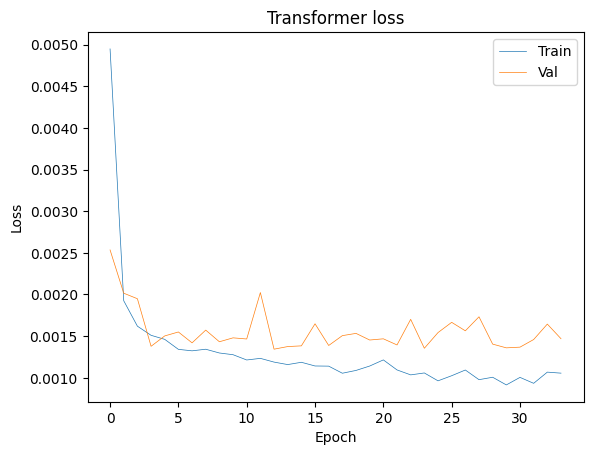

In [9]:
####### PLOT LOSS #######
plt.close()
plt.figure()
plt.plot(train_losses, label="Train", linewidth=0.5)
plt.plot(val_losses, label="Val", linewidth=0.5)
plt.title("Transformer loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.yscale("log")
plt.legend()
plt.savefig(os.path.join(plot_folder, "loss.png"))
plt.show()

### Open best model and plot some predictions

In [10]:

# model_path = os.path.join(model_folder, "GNN_best.pth")
# model.load_state_dict(torch.load(model_path))
model = best_model
n_labels = 2

# predict on test
model.eval()
pred = []
true = []
pull = []
std = []
errors = []
relative_errors = []
first_batch = True
with torch.no_grad():
    for i, (batch_input, batch_label) in enumerate(test_loader):
        batch_input[0] = batch_input[0].to(device)
        batch_label = batch_label.to(device)
        output = model(batch_input)
        # print(output.shape)
        error = (output - batch_label)
        relative_error = error / batch_label
        # append
        true.append(batch_label)
        pred.append(output)
        errors.append(error)
        relative_errors.append(relative_error)

true = torch.cat(true, dim=0).cpu().numpy()
pred = torch.cat(pred, dim=0).cpu().numpy()
errors = torch.cat(errors, dim=0).cpu().numpy()
relative_errors = torch.cat(relative_errors, dim=0).cpu().numpy()

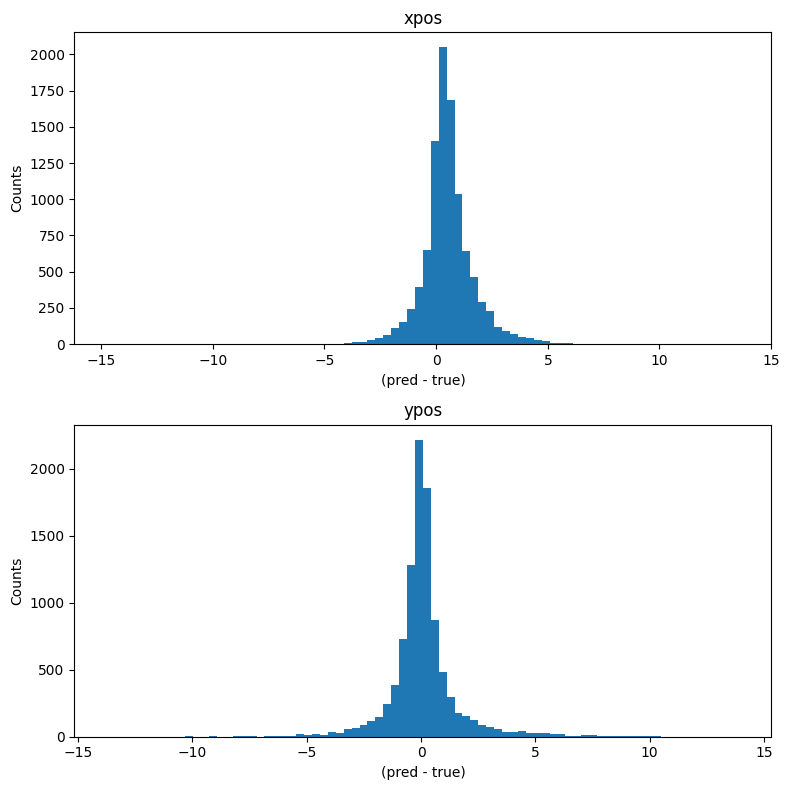

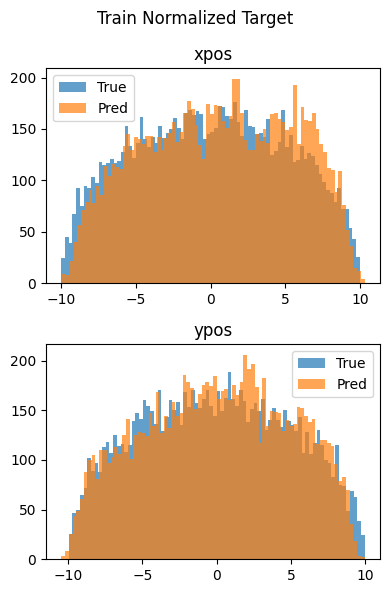

In [11]:
labelNames = ["xpos", "ypos"]
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
for i in range(2):
    axs[i].hist(errors[:, i] * label_stds[i], bins=80) # unnormalize (mean cancels, only need std)
    axs[i].set_title(labelNames[i])
    axs[i].set_xlabel("(pred - true)")
    axs[i].set_ylabel("Counts")
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "pred_errors.png"))

fig, axs = plt.subplots(2, figsize=(4, 6))
fig.suptitle("Train Normalized Target")
for i in range(2):
    axs[i].hist(true[:, i]* label_stds[i] + label_means[i], bins=80, alpha=0.7, label="True")
    axs[i].hist(pred[:, i]* label_stds[i] + label_means[i], bins=80, alpha=0.7, label="Pred")
    axs[i].set_title(labelNames[i])
    axs[i].legend()
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "pred.png"))

plt.show()

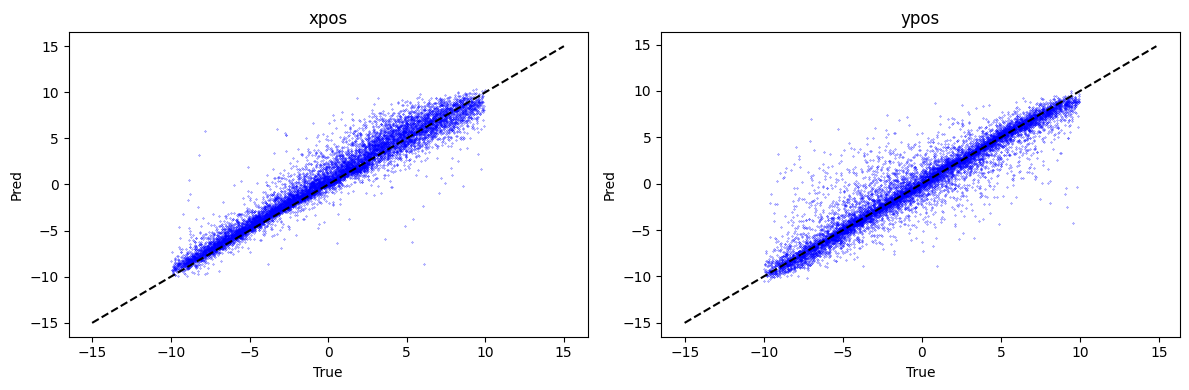

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# fig.suptitle("Predictions vs. True")
for i in range(2):
    axs[i].plot(true[:, i]* label_stds[i] + label_means[i], pred[:, i]* label_stds[i] + label_means[i], 'b.', markersize=0.5)
    axs[i].plot([label_means[i]-3*label_stds[i], label_means[i]+3*label_stds[i]], [label_means[i]-3*label_stds[i], label_means[i]+3*label_stds[i]], 'k--')
    axs[i].set_title(labelNames[i])
    axs[i].set_xlabel("True")
    axs[i].set_ylabel("Pred")
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "pred_vs_true.png"))
